This is a notebook to calculate the average delay between the onset of a behavior and a stimulus.  The delay is the number of time points between the marked start of the behavior and the start of the stimulus. 

In [18]:
import copy
import glob 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keller_zlatic_vnc.data_processing import find_before_and_after_events
from keller_zlatic_vnc.data_processing import generate_standard_id_for_full_annots
from keller_zlatic_vnc.data_processing import read_full_annotations
from keller_zlatic_vnc.data_processing import read_trace_data

In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
%matplotlib notebook

## Parameters go here

In [3]:
ps = dict()

# The file specifying which subjects we should include in the analysis
ps['subject_file'] = r'/Volumes/bishoplab/projects/keller_vnc/data/single_cell/subjects.csv'

# Location of files provided by Chen containing the raw fluorescence traces for the single cells
ps['trace_base_folder'] = r'/Volumes/bishoplab/projects/keller_vnc/data/single_cell/single_cell_traces'
ps['a00c_trace_folder'] = 'A00c'
ps['basin_trace_folder'] = 'Basin'
ps['handle_trace_folder'] = 'Handle'

# Location of folders containing annotations
ps['a4_annot_folder'] = r'/Volumes/bishoplab/projects/keller_vnc/data/full_annotations/behavior_csv_cl_A4'
ps['a9_annot_folder'] = r'/Volumes/bishoplab/projects/keller_vnc/data/full_annotations/behavior_csv_cl_A9'

# Parameters for declaring preceeding quiet behaviors
ps['pre_q_th'] = 50


## Read in the basic data for each subject

In [4]:
# Get the list of all subjects we need to process
subjects = list(pd.read_csv(ps['subject_file'])['Subject'])

In [5]:
data = read_trace_data(subjects=subjects, 
                   a00c_trace_folder=Path(ps['trace_base_folder'])/ps['a00c_trace_folder'], 
                   handle_trace_folder=Path(ps['trace_base_folder'])/ps['handle_trace_folder'], 
                   basin_trace_folder=Path(ps['trace_base_folder'])/ps['basin_trace_folder'])

No traces found for handle cells for subject CW_17-08-23-L1.
Done reading in data for subject 1 of 64.
Done reading in data for subject 2 of 64.
Done reading in data for subject 3 of 64.
Done reading in data for subject 4 of 64.
Done reading in data for subject 5 of 64.
Done reading in data for subject 6 of 64.
Done reading in data for subject 7 of 64.
Done reading in data for subject 8 of 64.
Done reading in data for subject 9 of 64.
Done reading in data for subject 10 of 64.
Done reading in data for subject 11 of 64.
Done reading in data for subject 12 of 64.
Done reading in data for subject 13 of 64.
Done reading in data for subject 14 of 64.
Done reading in data for subject 15 of 64.
No traces found for handle cells for subject CW_17-08-27-L3.
Done reading in data for subject 16 of 64.
Done reading in data for subject 17 of 64.
Done reading in data for subject 18 of 64.
Done reading in data for subject 19 of 64.
Done reading in data for subject 20 of 64.
Done reading in data for su

## Find stimulus events for the subjects we are analyzing

In [6]:
# Get list of subjects we have annotations for
a4_file_paths = glob.glob(str(Path(ps['a4_annot_folder']) / '*.csv'))
a9_file_paths = glob.glob(str(Path(ps['a9_annot_folder']) / '*.csv'))

n_annot_files = len(a4_file_paths) + len(a9_file_paths)
a4_files = np.zeros(n_annot_files, dtype=np.bool)
a4_files[0:len(a4_file_paths)] = True

annot_file_paths = a4_file_paths + a9_file_paths

annot_file_names = [Path(p).name for p in annot_file_paths]
annot_subjs = [generate_standard_id_for_full_annots(fn) for fn in annot_file_names]

In [7]:
# Get stimulus events for each subject we analyze
analysis_subjs = list(data['subject_id'].unique())
subj_events = pd.DataFrame()

for subj in analysis_subjs:
    
    # Find the annotations for this subject
    ind = np.argwhere(np.asarray(annot_subjs) == subj)
    if len(ind) == 0:
        raise(RuntimeError('Unable to find annotations for subject ' + subj + '.'))
    else:
        ind = ind[0][0]
        
    # Load the annotations for this subject
    tbl = read_full_annotations(annot_file_paths[ind])
    
    # Pull out stimulus events for this subject, noting what comes before and after
    stim_tbl = copy.deepcopy(tbl[tbl['beh'] == 'S'])
    stim_tbl.insert(0, 'subject_id', subj)
    stim_tbl.insert(1, 'event_id', range(stim_tbl.shape[0]))
    if a4_files[ind] == True:
        stim_tbl.insert(2, 'manipulation_tgt', 'A4')
    else:
        stim_tbl.insert(2, 'manipulation_tgt', 'A9')
    before_after_tbl = find_before_and_after_events(events=stim_tbl, all_events=tbl)
    stim_annots = pd.concat([stim_tbl, before_after_tbl], axis=1)
    subj_events = subj_events.append(stim_annots, ignore_index=True)


## Get rid of any events where we could not classify the type of preceeding or succeeding behavior 

In [9]:
subj_events = subj_events.dropna()

## Mark preceeding and succeeding quiet events

In [11]:
delta_before = subj_events['start'] - subj_events['beh_before_end']
before_quiet_inds = delta_before > ps['pre_q_th']
subj_events.loc[before_quiet_inds, 'beh_before'] = 'Q'

## Get the number of time points between start of non-quiet preceeding behaviors and stimulus

In [20]:
non_quiet_inds = subj_events['beh_before'] != 'Q'
# -1 below to get number between 
n_tm_pts_between = subj_events.loc[non_quiet_inds, 'start'] - subj_events.loc[non_quiet_inds, 'beh_before_start'] - 1
n_tm_pts_between = n_tm_pts_between.to_numpy()

(array([27., 11., 11., 30., 22., 19.,  9.,  3.,  3.,  1.]),
 array([1.0, 3.8, 6.6, 9.399999999999999, 12.2, 15.0, 17.799999999999997,
        20.599999999999998, 23.4, 26.2, 29.0], dtype=object),
 <BarContainer object of 10 artists>)

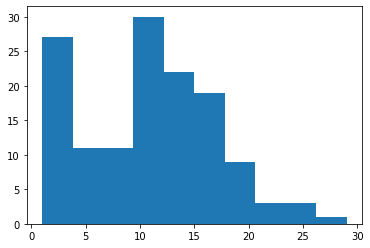

In [28]:
plt.figure()
plt.hist(n_tm_pts_between)

In [30]:
print('Mean # of Times Points Between start of behavior and stimulus onset: ' + str(np.mean(n_tm_pts_between)))

Mean # of Times Points Between start of behavior and stimulus onset: 10.860294117647058


In [26]:
sorted_before = np.sort(delta_before.to_numpy())

<IPython.core.display.Javascript object>


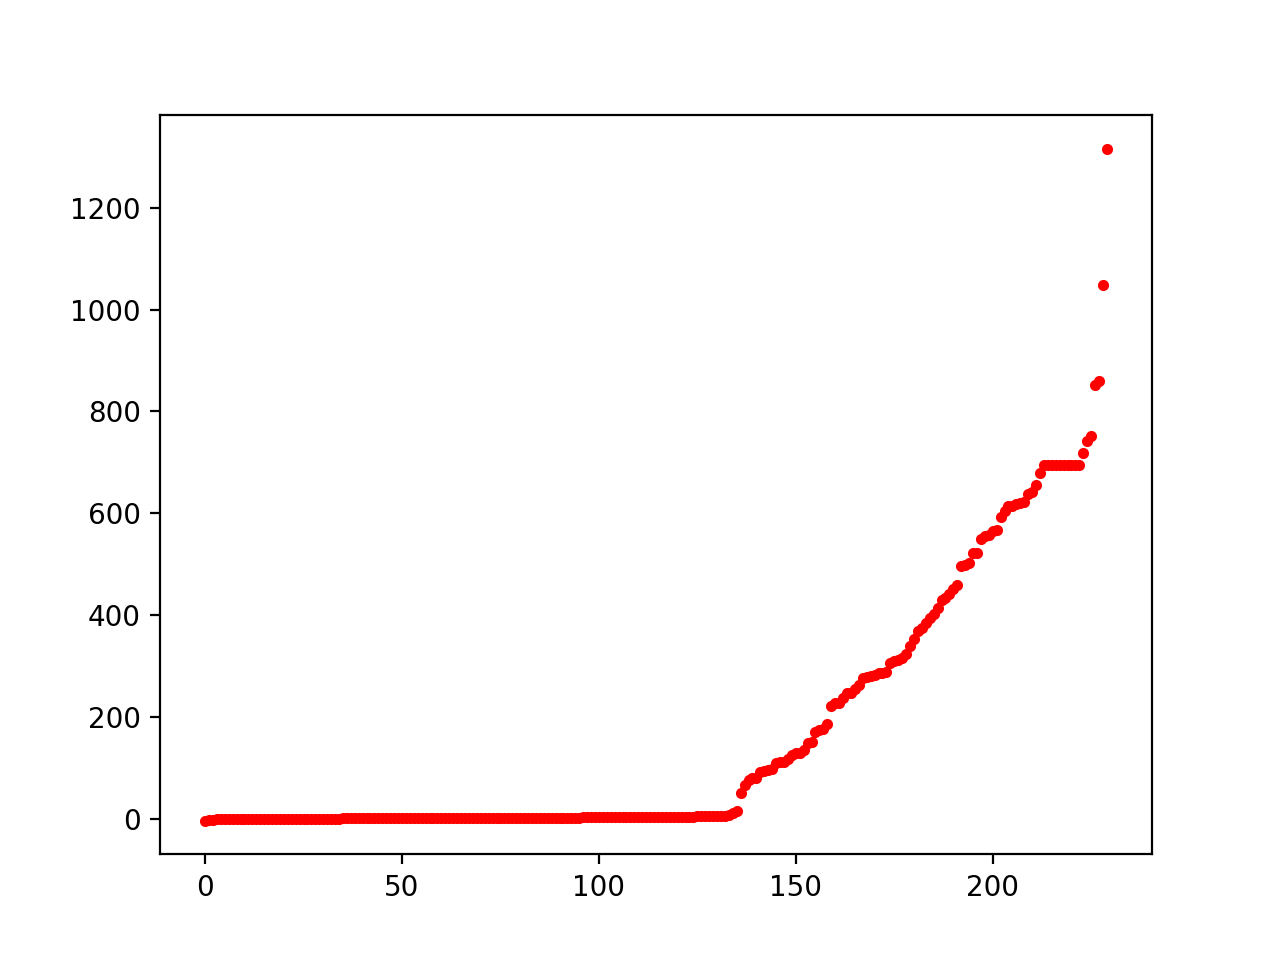

In [32]:
plt.plot(np.arange(len(sorted_before)), sorted_before, 'r.')